In [1]:
import numpy as np
import sys, os
import importlib
from scipy.signal import hilbert, kaiserord, firwin, filtfilt, freqz
from scipy.signal.windows import tukey
from scipy.interpolate import interp1d
import scipy.fft as fftpack
from obspy.geodetics.base import gps2dist_azimuth
from glob import glob
from os.path import join, basename

In [2]:
proj_path = '/home/shijie/data'
proj_name = 'huidong.DISP_2_1'
sys.path.append(proj_path)
par = importlib.import_module(proj_name + '.ftan_parameters')

In [3]:
def read_data(fpath):
    with open(fpath, 'r') as f:
        tmp = (f.readline()).split()
        lon1, lat1 = float(tmp[0]), float(tmp[1])
        tmp = (f.readline()).split()
        lon2, lat2 = float(tmp[0]), float(tmp[1])
    data = np.loadtxt(fpath, skiprows=2)
    maxamp = np.max(data[:,[1,2]])
    if maxamp > 0:
        data[:,[1,2]] /= maxamp
    if par.input_type == "CF":
        data[:,1] = np.imag(hilbert(data[:,1]))
        data[:,2] = np.imag(hilbert(data[:,2]))
    d, _, __ = gps2dist_azimuth(lat1, lon1, lat2, lon2)
    dist = d / 1000.0
    return data, dist


def cos_window(npts, n1, n2):
    window = np.zeros(npts)
    window[n1:n2] = 1
    taper_n = round((n2-n1)*0.05)
    window[n1:(n1+taper_n)] = np.sin(0.5*np.pi*np.arange(taper_n)/taper_n)
    window[(n2-taper_n):n2] = np.sin(0.5*np.pi*np.arange(taper_n,0,-1)/taper_n)
    return window


falpha = interp1d([0, 100, 250, 500, 1000, 2000, 4000, 20000],
                      [5, 8, 12, 20, 25, 35, 50, 75])

def gauss_window(alpha, freqs, cf):
    return np.exp(-alpha * ((freqs-cf)/cf)**2)

def envelope_image(par, time, signal, delta, dist):
    periods = par.periods
    alpha = falpha(dist)
    image = np.zeros([len(periods), len(signal)])
    P, T = np.meshgrid(periods, time, indexing='ij')
    VG = dist / T
    npts = len(signal)
    nfft = fftpack.next_fast_len(len(signal))
    fft = fftpack.rfft(signal, nfft)
    freqs = fftpack.rfftfreq(nfft, delta)
    for ip in range(len(periods)):
        cf = 1.0 / periods[ip]
        gs = gauss_window(alpha, freqs, cf)
        signal_f = fftpack.irfft(fft * gs, nfft)
        env_f = np.abs(hilbert(signal_f))
        env_f /= np.max(env_f)
        image[ip, :] = env_f[:npts]
    return P, VG, image

def phase_image_time_domain(par, time, signal, samplef, dist):
    """
    Deprecated
    low efficiency
    should pad signal when filter has comparable points as the signal
    """
    periods = par.periods
    numtaps, beta = kaiserord(par.ripple, par.width/(0.5*samplef))
    image = np.zeros([len(periods), len(signal)])
    P, T = np.meshgrid(periods, time, indexing='ij')
    VP = dist / (T - P/8)
    for ip in range(len(periods)):
        cf = 1.0 / periods[ip]
        w = par.band_pass_width / 2.0
        lc = 1.0 / (periods[ip]+w)
        hc = 1.0 / (periods[ip]-w)
        taps = firwin(numtaps, [lc, hc], window=('kaiser', beta), fs=samplef, pass_zero='bandpass')
        # print(len(taps), len(signal))
        signal_filtered = filtfilt(taps, 1, signal, padtype=None)
        signal_filtered /= np.max(signal_filtered)
        image[ip, :] = signal_filtered
    return P, VP, image

def phase_image(par, time, signal, samplef, dist):
    periods = par.periods
    numtaps, beta = kaiserord(par.ripple, par.width/(0.5*samplef))
    npts = len(signal)
    nfft = fftpack.next_fast_len(npts+numtaps)
    freqs = fftpack.rfftfreq(nfft, 1/samplef)
    image = np.zeros([len(periods), len(signal)])
    P, T = np.meshgrid(periods, time, indexing='ij')
    #TODO doublecheck
    VP = dist / (T - P/8)
    # VP = dist / T
    taper_window = tukey(npts, alpha=0.1)
    signal *= taper_window
    signal_fft = fftpack.rfft(signal, nfft)
    for ip in range(len(periods)):
        cf = 1.0 / periods[ip]
        w = par.band_pass_width / 2.0
        lc = 1.0 / (periods[ip]+w)
        hc = 1.0 / (periods[ip]-w)
        taps = firwin(numtaps, [lc, hc], window=('kaiser', beta), fs=samplef, pass_zero='bandpass')
        _, response = freqz(taps, worN=freqs, fs=samplef)
        signal_fft_filtered = signal_fft * np.abs(response)**2
        signal_filtered = np.real(fftpack.irfft(signal_fft_filtered))[:npts]
        signal_filtered /= np.max(signal_filtered)
        image[ip, :] = signal_filtered
    return P, VP, image

def nearest_max(data, ini):
    """
    Find index of nearest max
    data: input array
    ini: initial index
    Return
    isgood: boolean
    index_max: int, result
    """
    if data[ini+1] == data[ini]:
        return (False, 0)
    flag = int((data[ini+1] - data[ini]) / abs(data[ini+1] - data[ini]))
    iprev = ini
    inext = ini + flag
    while data[inext] > data[iprev]:
        iprev += flag
        inext += flag
        if inext > len(data)-1 or iprev < 0:
            return (False, 0)
    return (True, iprev)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def search_image(par, Img, Vels):
    if par.search_strategy == 'point':
        return search_image_point(par, Img, Vels)
    elif par.search_strategy == 'ref_curve':
        return search_image_refcurve(par, Img, Vels)

def search_image_refcurve(par, Img, Vels):
    periods = par.periods
    maxarr = np.zeros(len(periods))
    if np.any(np.isnan(Img)):
        return False, maxarr
    tmp = np.loadtxt(par.ref_disp_path)
    func = interp1d(tmp[:,0], tmp[:,1])
    refv = func(periods)
    # print("Reference dispersion curve:")
    # with np.printoptions(precision=3):
    #     print(periods)
    #     print(refv)
    for p_idx in range(len(periods)):
        refv_idx = find_nearest(Vels[p_idx], refv[p_idx])
        isgood, idx = nearest_max(Img[p_idx], refv_idx)
        if isgood:
            maxarr[p_idx] = Vels[p_idx, idx]
    return True, maxarr

def search_image_point(par, Img, Vels):
    periods = par.periods
    maxarr = np.zeros(len(periods))
    init_idx1 = find_nearest(periods, par.init_per)
    init_idx2 = find_nearest(Vels[init_idx1], par.init_phav)
    if init_idx2 >= len(Vels[init_idx1])-1:
        return False, maxarr
    if np.any(np.isnan(Img)):
        return False, maxarr
    prev_idx2 = init_idx2
    for ip in np.arange(init_idx1, len(periods)):
        isgood, idx = nearest_max(Img[ip], prev_idx2)
        if isgood:
            maxarr[ip] = Vels[ip, idx]
            prev_idx2 = idx
    prev_idx2 = init_idx2
    for ip in np.arange(init_idx1-1, -1, -1):
        isgood, idx = nearest_max(Img[ip], prev_idx2)
        if isgood:
            maxarr[ip] = Vels[ip, idx]
            prev_idx2 = idx
    return True, maxarr

def plot_phase_image(par, P, V, Img, pha_vels, out):
    import matplotlib as mpl
    mpl.use('Agg')
    import matplotlib.pyplot as plt

    periods = par.periods
    fig, ax = plt.subplots()
    fig.suptitle('dist %.2f km' % (dist))
    ax.contourf(P, V, Img, levels=50, cmap='viridis')
    if par.search_strategy == 'ref_curve':
        tmp = np.loadtxt(par.ref_disp_path)
        func = interp1d(tmp[:,0], tmp[:,1])
        refv = func(periods)
        ax.plot(periods, refv, color='tab:red', marker='.')
    ax.plot(periods, pha_vels, color='tab:blue', marker='.')
    ax.plot(periods, dist/par.min_lambda_ratio/periods, color='white')
    ax.set_ylim(par.minv, par.maxv)
    plt.savefig(out + '.png')
    plt.close()

In [4]:
all_inputs = glob(join(par.input_path, "*.dat"))
os.makedirs(par.output_path, exist_ok=True)
if par.is_save_fig:
    os.makedirs(par.fig_path, exist_ok=True)
periods = par.periods
n_inputs = len(all_inputs)

In [16]:
for ick in [10]:
    fpath = all_inputs[ick]
    data, dist = read_data(fpath)
    if dist < par.min_dist:
        continue
    time = data[:,0]
    delta = time[1] - time[0]
    samplef = 1.0 / delta
    n1 = int(dist/par.maxv/delta)
    n2 = int(dist/par.minv/delta)
    if n2 > len(time)-1:
        n2 = len(time)-1
    window = cos_window(len(time), n1, n2)
    stack_egf = data[:,1] + data[:,2]
    noise = stack_egf[n2:]
    stack_egf *= window
    P, VP, PhaImg = phase_image(par, time[n1:n2], stack_egf[n1:n2], samplef, dist)
    # P2, VG, GrpImg = envelope_image(par, time[n1:n2], stack_egf[n1:n2], delta, dist)
    is_good, pha_vels = search_image(par, PhaImg, VP)
    if not is_good:
        continue
    op = join(par.output_path, basename(fpath)+'.disp')
    oip = join(par.fig_path, basename(fpath))
    np.savetxt(op, np.c_[periods, pha_vels])
    if par.is_save_fig:
        plot_phase_image(par, P, VP, PhaImg, pha_vels, oip)

In [17]:
P2, VP2, PhaImg2 = phase_image(par, time, stack_egf, samplef, dist)
is_good2, pha_vels2 = search_image(par, PhaImg2, VP2)

/tmp/ipykernel_12854/4198000051.py:7: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  axes[1].pcolormesh(P2, VP2, PhaImg2, cmap='viridis')


(2.5, 4.0)

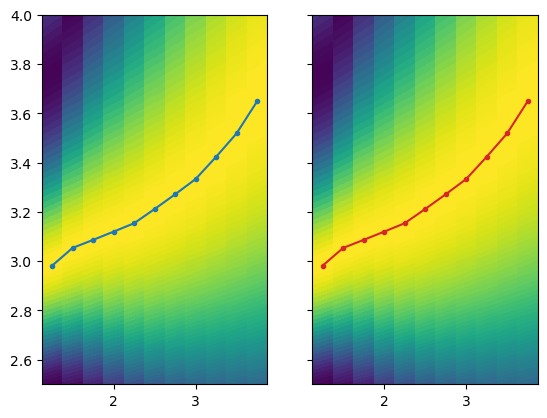

In [18]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=2, sharey=True)
axes[0].pcolormesh(P, VP, PhaImg, cmap='viridis')
axes[0].plot(periods, pha_vels, color='tab:blue', marker='.')
axes[1].plot(periods, pha_vels2, color='tab:red', marker='.')
axes[1].pcolormesh(P2, VP2, PhaImg2, cmap='viridis')
axes[0].set_ylim(2.5, 4.0)